# 05 Model Evaluation

- Model Evaluation
- Over-fitting, Under-fitting and Model Selection
- Ridge Regression
- Grid Search

# Evaluation

>How can you be certain the model works in the real world and performs optimally.

<p align="center"> 
<img src="../images/05_Model_Evaluation/01_evaluate/01_out_of_sample.png", width=800, height=600>|
</p>

## Dataset

In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore") 


# Import clean data 
url = 'https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DA0101EN/module_5_auto.csv'
df = pd.read_csv(url)

## Save dataset into data directory

In [2]:
df.to_csv('../data/module_5_auto.csv')

## Use numeric data

In [3]:
df = df._get_numeric_data()
df.head()

,Unnamed: 0,Unnamed: 0.1,symboling,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,...,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price,city-L/100km,diesel,gas
0,0,0,3,122,88.6,0.811148,0.890278,48.8,2548,130,...,2.68,9.0,111.0,5000.0,21,27,13495.0,11.190476,0,1
1,1,1,3,122,88.6,0.811148,0.890278,48.8,2548,130,...,2.68,9.0,111.0,5000.0,21,27,16500.0,11.190476,0,1
2,2,2,1,122,94.5,0.822681,0.909722,52.4,2823,152,...,3.47,9.0,154.0,5000.0,19,26,16500.0,12.368421,0,1
3,3,3,2,164,99.8,0.848630,0.919444,54.3,2337,109,...,3.40,10.0,102.0,5500.0,24,30,13950.0,9.791667,0,1
4,4,4,2,164,99.4,0.848630,0.922222,54.3,2824,136,...,3.40,8.0,115.0,5500.0,18,22,17450.0,13.055556,0,1


## Import plotting libraries

In [4]:
from IPython.display import display
from ipywidgets import widgets, interact, interactive, fixed, interact_manual

## Functions for plotting

In [5]:
def DistributionPlot(RedFunction, BlueFunction, RedName, BlueName, Title):
    width = 12
    height = 10
    plt.figure(figsize=(width, height))

    ax1 = sns.distplot(RedFunction, hist=False, color="r", label=RedName)
    ax2 = sns.distplot(BlueFunction, hist=False, color="b", label=BlueName, ax=ax1)

    plt.title(Title)
    plt.xlabel('Price (in dollars)')
    plt.ylabel('Proportion of Cars')
    
    title_str = Title.lower().replace(" ", "_") + '_distplot'
    filename = f'../figs/05_Model_Evaluation/02_select/{title_str}'
    plt.savefig(filename)

In [6]:
def PollyPlot(xtrain, xtest, y_train, y_test, lr, poly_transform):
    # xtrain, y_train: training data 
    # xtest, y_test: testing data 
    # lr:  linear regression object 
    # poly_transform:  polynomial transformation object
    
    width = 12
    height = 10
    plt.figure(figsize=(width, height))         
 
    xmax = max([xtrain.values.max(), xtest.values.max()])
    xmin = min([xtrain.values.min(), xtest.values.min()])

    x = np.arange(xmin, xmax, 0.1)

    plt.plot(xtrain, y_train, 'ro', label='Training Data')
    plt.plot(xtest, y_test, 'go', label='Test Data')
    plt.plot(x, lr.predict(poly_transform.fit_transform(x.reshape(-1, 1))), label='Predicted Function')
    plt.ylim([-10000, 60000])
    plt.ylabel('Price')
    plt.legend()    

# Training and Testing

### Split your data into training and testing data

<p align="center"> 
<img src="../images/05_Model_Evaluation/01_evaluate/02_split_dataset.png", width=800, height=600>|
</p>

<p align="center"> 
<img src="../images/05_Model_Evaluation/01_evaluate/03_training_testing.png", width=800, height=600>|
</p>

<p align="center"> 
<img src="../images/05_Model_Evaluation/01_evaluate/04_train_test_split.png", width=800, height=600>|
</p>

In [7]:
# place the target data price in a separate dataframe y
y_data = df['price']
y_data.head()

0    13495.0
1    16500.0
2    16500.0
3    13950.0
4    17450.0
Name: price, dtype: float64

In [8]:
# drop price data in x data
x_data=df.drop('price',axis=1)
x_data.head()

,Unnamed: 0,Unnamed: 0.1,symboling,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,city-L/100km,diesel,gas
0,0,0,3,122,88.6,0.811148,0.890278,48.8,2548,130,3.47,2.68,9.0,111.0,5000.0,21,27,11.190476,0,1
1,1,1,3,122,88.6,0.811148,0.890278,48.8,2548,130,3.47,2.68,9.0,111.0,5000.0,21,27,11.190476,0,1
2,2,2,1,122,94.5,0.822681,0.909722,52.4,2823,152,2.68,3.47,9.0,154.0,5000.0,19,26,12.368421,0,1
3,3,3,2,164,99.8,0.848630,0.919444,54.3,2337,109,3.19,3.40,10.0,102.0,5500.0,24,30,9.791667,0,1
4,4,4,2,164,99.4,0.848630,0.922222,54.3,2824,136,3.19,3.40,8.0,115.0,5500.0,18,22,13.055556,0,1


### Use the function "train_test_split" to split up the data set 
- 15% of the data samples will be utilized for testing
- set the parameter "random_state" equal to zero. 
- The output of the function should be the following: 
 - "x_train" , "x_test", "y_train" and "y_test"

In [9]:
# split our data into training and testing data
# using the function train_test_split.
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.15, random_state=0)

In [10]:
print(f"number of test samples : { x_test.shape[0]}")
print(f"number of training samples: {x_train.shape[0]}")

number of test samples : 31
number of training samples: 170


In [11]:
# Import LinearRegression from the module linear_model
from sklearn.linear_model import LinearRegression

In [12]:
# Create a Linear Regression object:
lre=LinearRegression()

In [13]:
# Fit the model using the feature horsepower
lre.fit(x_train[['horsepower']], y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [14]:
# Calculate the R^2 on the test data:
r_squared = lre.score(x_test[['horsepower']], y_test)
print(f"R^2 on the test data  = {r_squared:.5f}")

R^2 on the test data  = 0.79231


### Use the function "train_test_split" to split up the data set 
- 40% of the data samples will be utilized for testing
- set the parameter "random_state" equal to zero. 
- The output of the function should be the following: 
 - "x_train_1" , "x_test_1", "y_train_1" and "y_test_1"

In [15]:
# split our data into training and testing data
# using the function train_test_split.
from sklearn.model_selection import train_test_split
x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(x_data, y_data, test_size=0.40, random_state=0)

In [16]:
print(f"number of test samples : { x_test_1.shape[0]}")
print(f"number of training samples: {x_train_1.shape[0]}")

number of test samples : 81
number of training samples: 120


In [17]:
# Import LinearRegression from the module linear_model
from sklearn.linear_model import LinearRegression

In [18]:
# Create a Linear Regression object:
lre1=LinearRegression()

In [19]:
# Fit the model using the feature horsepower
lre1.fit(x_train_1[['horsepower']], y_train_1)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [20]:
# Calculate the R^2 on the test data:
r_squared = lre1.score(x_test_1[['horsepower']], y_test_1)
print(f"R^2 on the test data 1 = {r_squared:.5f}")

R^2 on the test data 1 = 0.71394


### R^2 is much smaller using the test data

### Find the R^2 on the test data using 90% of the data for training data

In [21]:
x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(x_data, y_data, test_size=0.10, random_state=0)

In [22]:
print(f"number of test samples : { x_test_2.shape[0]}")
print(f"number of training samples: {x_train_2.shape[0]}")

number of test samples : 21
number of training samples: 180


In [23]:
from sklearn.linear_model import LinearRegression
lre2 = LinearRegression()
lre2.fit(x_train_2[['horsepower']], y_train_2)
r_squared = lre2.score(x_test_2[['horsepower']], y_test_2)
print(f"R^2 on the test data 2 = {r_squared:.5f}")

R^2 on the test data 2 = 0.73407


## Cross-validation

<p align="center"> 
<img src="../images/05_Model_Evaluation/01_evaluate/05_generalization_error.png", width=800, height=600>|
</p>

<p align="center"> 
<img src="../images/05_Model_Evaluation/01_evaluate/06_generalization_error_train_test.png", width=800, height=600>|
</p>

<p align="center"> 
<img src="../images/05_Model_Evaluation/01_evaluate/07_train_test.png", width=800, height=600>|
</p>

<p align="center"> 
<img src="../images/05_Model_Evaluation/01_evaluate/08_good_accuracy_poor_precision.png", width=800, height=600>|
</p>

<p align="center"> 
<img src="../images/05_Model_Evaluation/01_evaluate/09_poor_accuracy_good_precision.png", width=800, height=600>|
</p>

## Cross-validation Score

### Perform Cross-validation when you do not have sufficient testing data
>All  error estimates are relatively close together,
but they are further away from the true generalization performance.
- To overcome this problem, we use cross validation.

<p align="center"> 
<img src="../images/05_Model_Evaluation/01_evaluate/10_cross_validation.png", width=800, height=600>|
</p>

<p align="center"> 
<img src="../images/05_Model_Evaluation/01_evaluate/11_cross_val_score_1.png", width=800, height=600>|
</p>

<p align="center"> 
<img src="../images/05_Model_Evaluation/01_evaluate/12_cross_val_score_2.png", width=800, height=600>|
</p>

<p align="center"> 
<img src="../images/05_Model_Evaluation/01_evaluate/13_cross_val_score_3.png", width=800, height=600>|
</p>

In [24]:
# import cross_val_score from the module model_selection.
from sklearn.model_selection import cross_val_score

In [25]:
# input the object, 
# the feature 'horsepower' in this case, 
# the target data (y_data). 
# parameter 'cv' determines the number of folds; 4 in this case.
Rcross = cross_val_score(lre, x_data[['horsepower']], y_data, cv=4)

In [26]:
# The default scoring is R^2; 
# each element in the array has the average R^2 value in the fold:
Rcross

array([0.7746232 , 0.51716687, 0.74785353, 0.04839605])

In [27]:
# Calculate average and standard deviation of the estimate
print(f"Mean of the folds are {Rcross.mean():.5f}")
print(f"Standard deviation is {Rcross.std():.5f}")

Mean of the folds are 0.52201
Standard deviation is 0.29118


In [28]:
# use mean squared error as a score 
# by setting the parameter 'scoring' metric to 'neg_mean_squared_error'.
mse_cross = -1 * cross_val_score(lre,x_data[['horsepower']], y_data,cv=4,scoring='neg_mean_squared_error')
['{:,.0f}'.format(i) for i in mse_cross.tolist()]

['20,254,143', '43,745,493', '12,539,630', '17,561,928']

### Calculate the average R^2 using two folds

>Calculate the average R^2 using two folds
- find the average R^2 for the second fold utilizing the horsepower as a feature

In [29]:
Rcross2 = cross_val_score(lre, x_data[['horsepower']], y_data, cv=2)
Rcross2_str  = ['{:.5f}'.format(i) for i in Rcross2.tolist()]
print(f"R^2 using two folds : {Rcross2_str}")
print(f"Average R^2 using two folds = {Rcross2.mean():.5f}")
print(f"Standard deviation is {Rcross2.std():.5f}")

R^2 using two folds : ['0.59016', '0.44320']
Average R^2 using two folds = 0.51668
Standard deviation is 0.07348


### Predict using cross_val_predict

<p align="center"> 
<img src="../images/05_Model_Evaluation/01_evaluate/14_cross_val_predict_1.png", width=800, height=600>|
</p>

<p align="center"> 
<img src="../images/05_Model_Evaluation/01_evaluate/15_cross_val_predict_2.png", width=800, height=600>|
</p>

<p align="center"> 
<img src="../images/05_Model_Evaluation/01_evaluate/16_cross_val_predict_3.png", width=800, height=600>|
</p>

<p align="center"> 
<img src="../images/05_Model_Evaluation/01_evaluate/17_cross_val_predict_4.png", width=800, height=600>|
</p>

In [30]:
# use the function 'cross_val_predict' to predict the output. 
# splits up the data into the specified number of folds, 
# using one fold to get a prediction
# while the rest of the folds are used as test data

from sklearn.model_selection import cross_val_predict

yhat = cross_val_predict(lre,x_data[['horsepower']], y_data,cv=4)
['{:,.0f}'.format(i) for i in yhat[0:5].tolist()]

['14,142', '14,142', '20,814', '12,745', '14,762']

# Overfitting, Underfitting and Model Selection

### How to pick the best polynomial order?
- Assume the training points come from a polynomial function plus some noise.
- The goal of model selection is to determine the order of the polynomial to provide the best estimate of the function $y$ = $f(x)$

### Select polynomial order that minimizes the test error
- **Any order less is considered under-fitting.**
- **Any order more is considered over-fitting.**

<p align="center"> 
<img src="../images/05_Model_Evaluation/02_select/01_true_function.png", width=800, height=600>|
</p>

<p align="center"> 
<img src="../images/05_Model_Evaluation/02_select/02_sample_points_true_function_noise.png", width=800, height=600>|
</p>

<p align="center"> 
<img src="../images/05_Model_Evaluation/02_select/03_underfit_linear_model.png", width=800, height=600>|
</p>

<p align="center"> 
<img src="../images/05_Model_Evaluation/02_select/04_underfit_2_poly.png", width=800, height=600>|
</p>

<p align="center"> 
<img src="../images/05_Model_Evaluation/02_select/05_fit_8_poly.png", width=800, height=600>|
</p>

<p align="center"> 
<img src="../images/05_Model_Evaluation/02_select/06_overfit_16_poly.png", width=800, height=600>|
</p>

In [31]:
# Create Multiple linear regression objects and train the model 
# using 'horsepower', 'curb-weight', 'engine-size' and 'highway-mpg' as features.
lr = LinearRegression()
lr.fit(x_train[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']], y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [32]:
# Prediction using training data:
yhat_train = lr.predict(x_train[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']])
['{:,.0f}'.format(i) for i in yhat_train[0:5].tolist()]

['10,028', '7,611', '20,199', '8,332', '11,254']

In [33]:
#Prediction using test data
yhat_test = lr.predict(x_test[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']])
['{:,.0f}'.format(i) for i in yhat_test[0:5].tolist()]

['5,131', '10,413', '19,890', '21,975', '20,760']

In [34]:
# Perform some model evaluation using our training and testing data separately.
# First we import the seaborn and matplotlibb library for plotting.
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

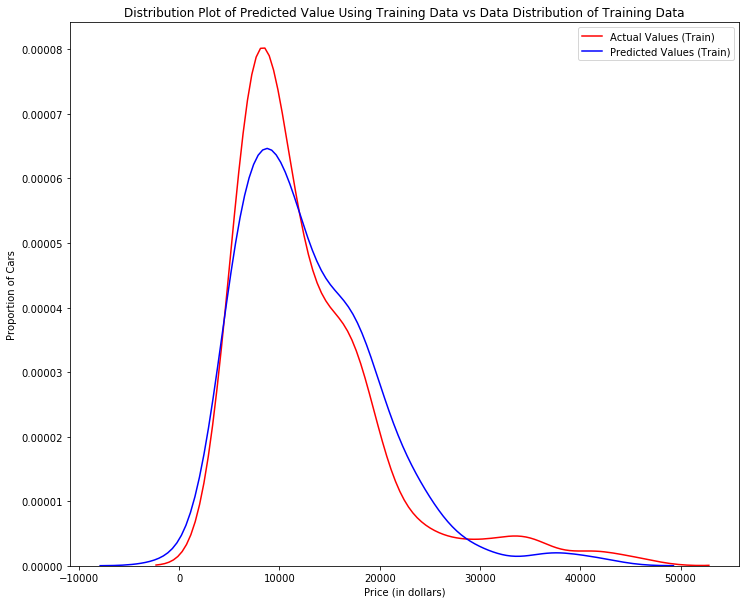

In [35]:
# Examine the distribution of the predicted values of the training data.
Title = 'Distribution Plot of Predicted Value Using Training Data vs Data Distribution of Training Data'
DistributionPlot(y_train, yhat_train, "Actual Values (Train)", "Predicted Values (Train)", Title)

### Plot of predicted values using the training data compared to the actual training data.

>Model seems to be doing well in learning from the training dataset. 

>When the model generates new values from the test data, we see the distribution of the predicted values is much different from the actual target values.

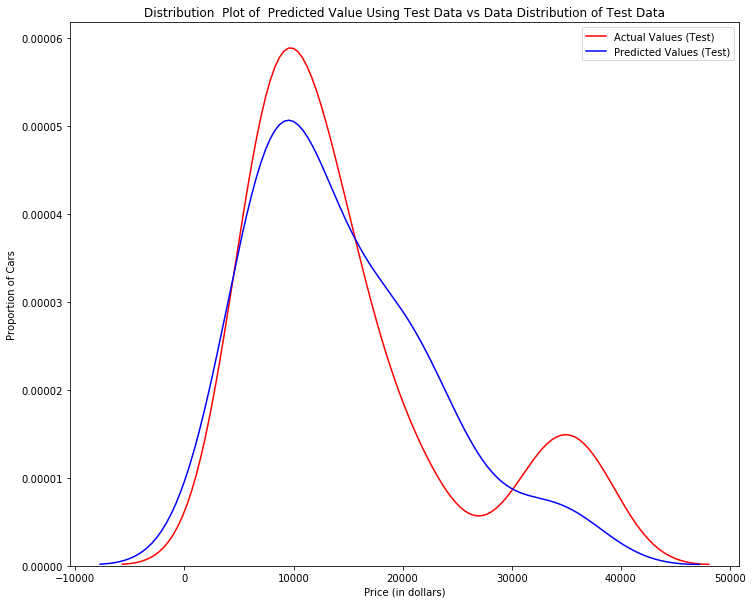

In [36]:
Title='Distribution  Plot of  Predicted Value Using Test Data vs Data Distribution of Test Data'
DistributionPlot(y_test,yhat_test,"Actual Values (Test)","Predicted Values (Test)",Title)

### Plot of predicted value using the test data compared to the test data.

>Comparing the figures
>The distribution of the test data in first figure is much better at fitting the data. 

>This difference in second figure is apparent where the ranges are from 5000 to 15 000. 

>This is where the distribution shape is exceptionally different. 

In [37]:
# see if polynomial regression also exhibits a drop in the prediction accuracy when analysing the test dataset.
from sklearn.preprocessing import PolynomialFeatures

## Overfitting

### Overfitting occurs when the model fits the noise, not the underlying process. 

> when testing your model using the test-set, your model does not perform as well as it is modelling noise, not the underlying process that generated the relationship. 

<p align="center"> 
<img src="../images/05_Model_Evaluation/02_select/07_train_error.png", width=800, height=600>|
</p>

<p align="center"> 
<img src="../images/05_Model_Evaluation/02_select/08_test_error.png", width=800, height=600>|
</p>

<p align="center"> 
<img src="../images/05_Model_Evaluation/02_select/09_select_min_test_error.png", width=800, height=600>|
</p>

<p align="center"> 
<img src="../images/05_Model_Evaluation/02_select/10_ irreducible_ error_random_noise_term.png", width=800, height=600>|
</p>

<p align="center"> 
<img src="../images/05_Model_Evaluation/02_select/11_wrong_poly_sin.png", width=800, height=600>|
</p>

<p align="center"> 
<img src="../images/05_Model_Evaluation/02_select/12_mean_order_0_poly.png", width=800, height=600>|
</p>

<p align="center"> 
<img src="../images/05_Model_Evaluation/02_select/13_linear_order_1_poly.png", width=800, height=600>|
</p>

<p align="center"> 
<img src="../images/05_Model_Evaluation/02_select/14_order_2_poly.png", width=800, height=600>|
</p>

<p align="center"> 
<img src="../images/05_Model_Evaluation/02_select/15_order_3_poly.png", width=800, height=600>|
</p>

<p align="center"> 
<img src="../images/05_Model_Evaluation/02_select/16_order_4_poly_200_hp.png", width=800, height=600>|
</p>

### Create a degree 5 polynomial model

In [38]:
# use 55 percent of the data for testing and the rest for training
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.45, random_state=0)

In [39]:
# Perform a degree 5 polynomial transformation on the feature 'horse power'.
from sklearn.preprocessing import PolynomialFeatures
pr = PolynomialFeatures(degree=5)
x_train_pr = pr.fit_transform(x_train[['horsepower']])
x_test_pr = pr.fit_transform(x_test[['horsepower']])
pr

PolynomialFeatures(degree=5, include_bias=True, interaction_only=False,
                   order='C')

### Create a linear regression model "poly" and train it.

In [40]:
poly = LinearRegression()
poly.fit(x_train_pr, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [41]:
# See the output of our model using the method "predict." then 
# assign the values to "yhat".

yhat = poly.predict(x_test_pr)
yhat = [float('{:.1f}'.format(i)) for i in yhat[0:4]]

In [42]:
# Take the first five predicted values and 
# compare it to the actual targets.

print(f"Predicted values: {yhat}")
print(f"True values     : {y_test[0:4].values}")

Predicted values: [6728.7, 7308.0, 12213.8, 18893.2]
True values     : [ 6295. 10698. 13860. 13499.]


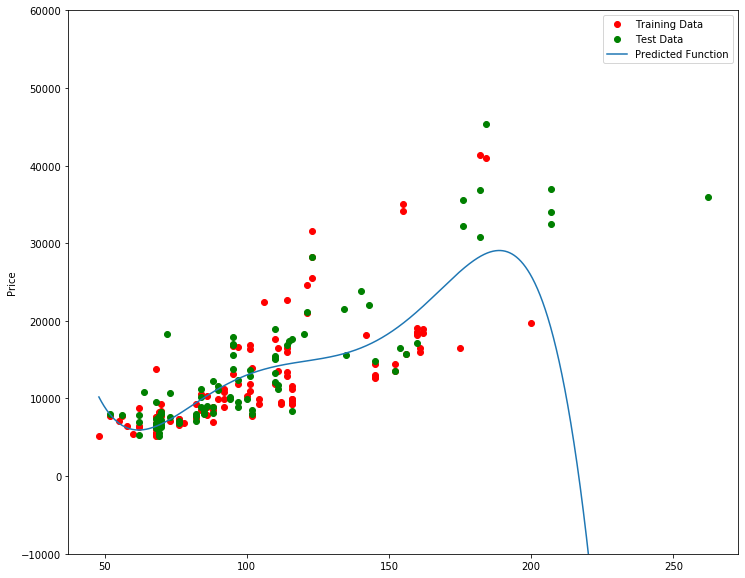

In [43]:
# Use PollyPlot to display the training data, testing data, and the predicted function.

PollyPlot(x_train[['horsepower']], x_test[['horsepower']], y_train, y_test, poly,pr)
plt.gcf()
filename = f'../figs/05_Model_Evaluation/02_select/degree5_poly_horse_power.png'
plt.savefig(filename)

### Polynomial regression model
- red dots represent training data
- green dots represent test data
- blue line represents the model prediction.

>The estimated function appears to track the data but around 200 horsepower, the function begins to diverge from the data points.

In [44]:
# R^2 of the training data

r_squared = poly.score(x_train_pr, y_train)
print(f"R^2 on the training data = {r_squared:.5f}")

R^2 on the training data = 0.55677


In [45]:
#R^2 of the test data

r_squared = poly.score(x_test_pr, y_test)
print(f"R^2 on the test data = {r_squared:.5f}")

R^2 on the test data = -29.87134


### R^2 for the training data is 0.5567 while the R^2 on the test data was -29.87. 
- The lower the R^2, the worse the model
- Negative R^2 is a sign of overfitting.

### R^2 Using Test Data

<p align="center"> 
<img src="../images/05_Model_Evaluation/02_select/17_max_r_squared_order_3.png", width=800, height=600>|
</p>

<p align="center"> 
<img src="../images/05_Model_Evaluation/02_select/18_calculate_r_squared_orders.png", width=800, height=600>|
</p>

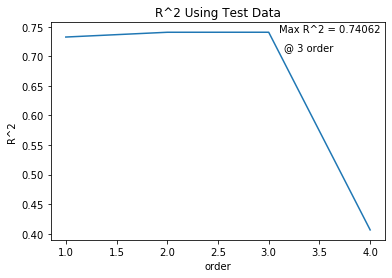

In [46]:
# How the R^2 changes on the test data for different order polynomials and
# plot the results

Rsqu_test = []

order = [1, 2, 3, 4]
for n in order:
    pr = PolynomialFeatures(degree=n)
    
    x_train_pr = pr.fit_transform(x_train[['horsepower']])
    
    x_test_pr = pr.fit_transform(x_test[['horsepower']])    
    
    lr.fit(x_train_pr, y_train)
    
    Rsqu_test.append(lr.score(x_test_pr, y_test))
    
Rsqu_max = max(Rsqu_test)
Rsqu_max_order = Rsqu_test.index(Rsqu_max) + 1

Rsqu_max_str = f'Max R^2 = {Rsqu_max:.5f}'
Rsqu_max_order_str = f'@ {Rsqu_max_order} order'

plt.plot(order, Rsqu_test)
plt.xlabel('order')
plt.ylabel('R^2')
plt.title('R^2 Using Test Data')
plt.text(Rsqu_max_order+0.1, Rsqu_max, Rsqu_max_str)
plt.text(Rsqu_max_order+0.15, Rsqu_max-0.03, Rsqu_max_order_str)

plt.savefig('../figs/05_Model_Evaluation/02_select/r_squared_order_horsepower.png')

### R^2 gradually increases until an order three polynomial is used. Then the R^2 dramatically decreases at four.

### Experiment with different polynomial orders

In [47]:
# The function f is used to experiment with different polynomial orders
def f(order, test_data):
    x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=test_data, random_state=0)
    pr = PolynomialFeatures(degree=order)
    x_train_pr = pr.fit_transform(x_train[['horsepower']])
    x_test_pr = pr.fit_transform(x_test[['horsepower']])
    poly = LinearRegression()
    poly.fit(x_train_pr,y_train)
    PollyPlot(x_train[['horsepower']], x_test[['horsepower']], y_train,y_test, poly, pr)

In [48]:
# Experiment with different polynomial orders and different amounts of data.
interact(f, order=(0, 6, 1), test_data=(0.05, 0.95, 0.05));

interactive(children=(IntSlider(value=3, description='order', max=6), FloatSlider(value=0.45, description='tes…

### Create a "PolynomialFeatures" object "pr1" of degree two

In [49]:
pr1 = PolynomialFeatures(degree=2)
pr1

PolynomialFeatures(degree=2, include_bias=True, interaction_only=False,
                   order='C')

### Transform the training and testing samples for the features 'horsepower', 'curb-weight', 'engine-size' and 'highway-mpg'.

In [50]:
x_train_pr1 = pr1.fit_transform(x_train[['horsepower', 'curb-weight', 'engine-size' , 'highway-mpg']])
x_test_pr1 = pr1.fit_transform(x_test[['horsepower', 'curb-weight', 'engine-size' , 'highway-mpg']])

In [51]:
x_train_pr1.shape[1]

15

### Create a linear regression model "poly1" and train the object 

In [52]:
poly1 = LinearRegression()
poly1.fit(x_train_pr1, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

### Use the method "predict" to predict an output on the polynomial features

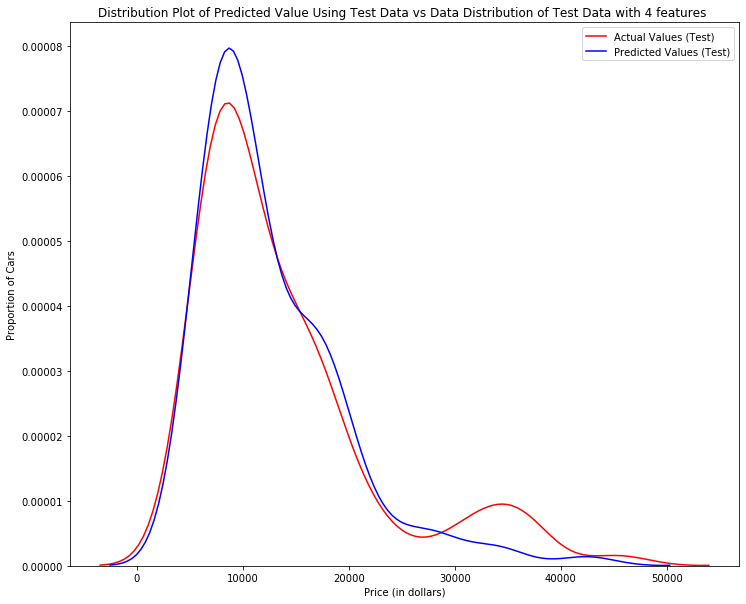

In [53]:
yhat_test1=poly1.predict(x_train_pr1)
Title='Distribution Plot of Predicted Value Using Test Data vs Data Distribution of Test Data with 4 features '
DistributionPlot(y_test, yhat_test1, "Actual Values (Test)", "Predicted Values (Test)", Title)

### Use the distribution plot to determine the two regions were the predicted prices are less accurate than the actual prices.

>The predicted value is lower than actual value for cars where the price around 10,000

> the predicted price is larger than the price cost from 30,000 to 40,000 

# Ridge regression

- Ridge regression controls the large magnitude of the polynomial coefficients by introducing the parameter alpha.
- Alpha
 - a parameter to select before fitting or training the model
- Ridge regression is used to prevent over-fitting.
- Consider how the estimated function is approximating the true function.
- real data has outliers

<p align="center"> 
<img src="../images/05_Model_Evaluation/03_ridge/01_true_function_samples_order_4.png", width=800, height=600>|
</p>

<p align="center"> 
<img src="../images/05_Model_Evaluation/03_ridge/02_true_function_samples_model_order_4.png", width=800, height=600>|
</p>

<p align="center"> 
<img src="../images/05_Model_Evaluation/03_ridge/03_true_function_samples_model_order_10.png", width=800, height=600>|
</p>

<p align="center"> 
<img src="../images/05_Model_Evaluation/03_ridge/04_alpha.png", width=800, height=600>|
</p>

<p align="center"> 
<img src="../images/05_Model_Evaluation/03_ridge/05_alpha_coefs.png", width=800, height=600>|
</p>

<p align="center"> 
<img src="../images/05_Model_Evaluation/03_ridge/06_alpha_0.png", width=800, height=600>|
</p>

<p align="center"> 
<img src="../images/05_Model_Evaluation/03_ridge/07_alpha_001.png", width=800, height=600>|
</p>

<p align="center"> 
<img src="../images/05_Model_Evaluation/03_ridge/08_alpha_01.png", width=800, height=600>|
</p>

<p align="center"> 
<img src="../images/05_Model_Evaluation/03_ridge/09_alpha_1.png", width=800, height=600>|
</p>

<p align="center"> 
<img src="../images/05_Model_Evaluation/03_ridge/10_alpha_10.png", width=800, height=600>|
</p>

<p align="center"> 
<img src="../images/05_Model_Evaluation/03_ridge/11_predict_ridge.png", width=800, height=600>|
</p>

In [54]:
# Perform a degree two polynomial transformation on our data.
pr=PolynomialFeatures(degree=2)
x_train_pr=pr.fit_transform(x_train[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg','normalized-losses','symboling']])
x_test_pr=pr.fit_transform(x_test[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg','normalized-losses','symboling']])

In [55]:
# Import Ridge from the module linear model.
from sklearn.linear_model import Ridge

In [56]:
# Create a Ridge regression object
# setting the regularization parameter to 0.1
RigeModel=Ridge(alpha=0.1)

In [57]:
# Fit the model using the method fit.
RigeModel.fit(x_train_pr, y_train)

Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [58]:
# Obtain a prediction:
yhat = RigeModel.predict(x_test_pr)
yhat = [float('{:.1f}'.format(i)) for i in yhat[0:4]]

In [59]:
# Compare the first five predicted samples to the test set
print(f'predicted: {yhat[0:4]}')
print(f'test set : { y_test[0:4].values}')

predicted: [6567.8, 9598.0, 20836.2, 19347.7]
test set : [ 6295. 10698. 13860. 13499.]


## How to Select the Value of alpha

<p align="center"> 
<img src="../images/05_Model_Evaluation/03_ridge/12_select_alpha_1.png", width=800, height=600>|
</p>

<p align="center"> 
<img src="../images/05_Model_Evaluation/03_ridge/13_select_alpha_2.png", width=800, height=600>|
</p>

<p align="center"> 
<img src="../images/05_Model_Evaluation/03_ridge/14_select_alpha_3_calc_r_squared.png", width=800, height=600>|
</p>

<p align="center"> 
<img src="../images/05_Model_Evaluation/03_ridge/15_select_alpha_4_max_r_squared.png", width=800, height=600>|
</p>

<p align="center"> 
<img src="../images/05_Model_Evaluation/03_ridge/16_train_val_alpha_r_squared.png", width=800, height=600>|
</p>

In [60]:
# Select the value of alpha that minimizes the test error
Rsqu_test = []
Rsqu_train = []
dummy1 = []
alphas = 10 * np.array(range(0,1000))
for a in alphas:
    RigeModel = Ridge(alpha=a) 
    RigeModel.fit(x_train_pr, y_train)
    Rsqu_test.append(RigeModel.score(x_test_pr, y_test))
    Rsqu_train.append(RigeModel.score(x_train_pr, y_train))

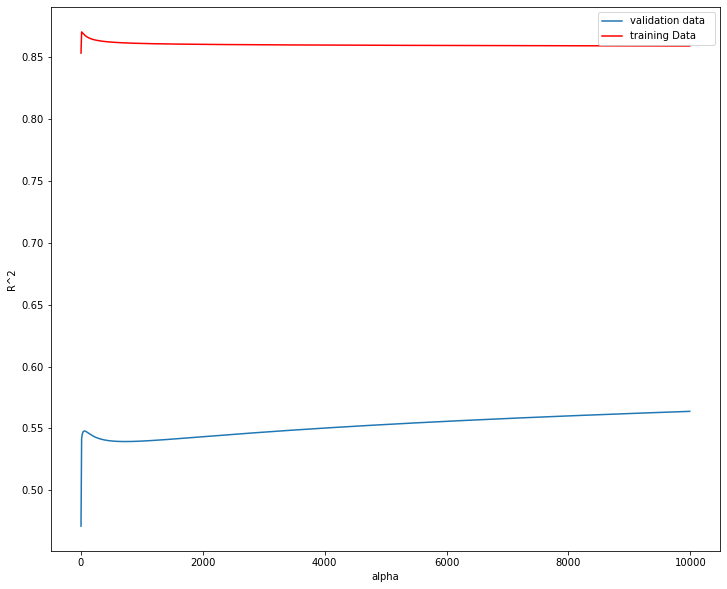

In [61]:
# Plot out the value of R^2 for different Alphas
width = 12
height = 10
plt.figure(figsize=(width, height))

plt.plot(alphas,Rsqu_test, label='validation data  ')
plt.plot(alphas,Rsqu_train, 'r', label='training Data ')
plt.xlabel('alpha')
plt.ylabel('R^2')
plt.legend()

plt.savefig('../figs/05_Model_Evaluation/03_ridge/r_squared_alpha.png')

- The blue line represents the R^2 of the test data
- The red line represents the R^2 of the training data. 
- The x-axis represents the different values of alpha

>As alpha increases the R^2 decreases; therefore as alpha increases the model performs worse on the test data. 

>The blue line represents the R^2 on the validation data, as the value for alpha increases the R^2 decreases.

### Perform Ridge regression 
- Calculate the R^2 using the polynomial features
- Use the training data to train the model and test data to test the model. 
- The parameter alpha should be set to 10.

In [62]:
RigeModel = Ridge(alpha=10) 
RigeModel.fit(x_train_pr, y_train)
r_squared = RigeModel.score(x_test_pr, y_test)
print(f"R^2 for the ridge model  = {r_squared:.5f}")


R^2 for the ridge model  = 0.54186


# Grid Search

### The term alpha is a hyperparameter
>sklearn has the class GridSearchCV to make the process of finding the best hyperparameter simpler.

<p align="center"> 
<img src="../images/05_Model_Evaluation/04_grid/01_hyperparameter_1.png", width=800, height=600>|
</p>

<p align="center"> 
<img src="../images/05_Model_Evaluation/04_grid/02_hyperparameter_2.png", width=800, height=600>|
</p>

<p align="center"> 
<img src="../images/05_Model_Evaluation/04_grid/03_hyperparameter_3.png", width=800, height=600>|
</p>

<p align="center"> 
<img src="../images/05_Model_Evaluation/04_grid/04_train_valid_test_1.png", width=800, height=600>|
</p>

<p align="center"> 
<img src="../images/05_Model_Evaluation/04_grid/05_train_valid_test_2.png", width=800, height=600>|
</p>

<p align="center"> 
<img src="../images/05_Model_Evaluation/04_grid/06_train_valid_test_3.png", width=800, height=600>|
</p>

<p align="center"> 
<img src="../images/05_Model_Evaluation/04_grid/07_train_valid_test_4.png", width=800, height=600>|
</p>

<p align="center"> 
<img src="../images/05_Model_Evaluation/04_grid/08_alpha_normalize.png", width=800, height=600>|
</p>

<p align="center"> 
<img src="../images/05_Model_Evaluation/04_grid/09_alpha_values.png", width=800, height=600>|
</p>

<p align="center"> 
<img src="../images/05_Model_Evaluation/04_grid/10_gridsearch_1.png", width=800, height=600>|
</p>

<p align="center"> 
<img src="../images/05_Model_Evaluation/04_grid/11_gridsearch_2.png", width=800, height=600>|
</p>

<p align="center"> 
<img src="../images/05_Model_Evaluation/04_grid/12_gridsearch_3.png", width=800, height=600>|
</p>

In [63]:
# import GridSearchCV from the module model_selection.
from sklearn.model_selection import GridSearchCV

In [64]:
# Create a dictionary of parameter values
parameters1= [{'alpha': [0.001,0.1,1, 10, 100, 1000, 10000, 100000, 100000]}]
parameters1

[{'alpha': [0.001, 0.1, 1, 10, 100, 1000, 10000, 100000, 100000]}]

In [65]:
# Create a ridge egression object:
RR=Ridge()
RR

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [66]:
# Create a ridge grid search object
Grid1 = GridSearchCV(RR, parameters1,cv=4, iid='deprecated')

In [67]:
# Fit the model
Grid1.fit(x_data[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']], y_data)

GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=None,
             param_grid=[{'alpha': [0.001, 0.1, 1, 10, 100, 1000, 10000, 100000,
                                    100000]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [68]:
# The object finds the best parameter values on the validation data.
# Obtain the estimator with the best parameters and 
# assign it to the variable BestRR 

BestRR=Grid1.best_estimator_
BestRR

Ridge(alpha=10000, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [69]:
scores1 = Grid1.cv_results_
for param, mean_test in zip(scores1['params'], scores1['mean_test_score']):
    print(f'{param} R^2 on test data: {mean_test:.5f}')

{'alpha': 0.001} R^2 on test data: 0.66549
{'alpha': 0.1} R^2 on test data: 0.66549
{'alpha': 1} R^2 on test data: 0.66549
{'alpha': 10} R^2 on test data: 0.66555
{'alpha': 100} R^2 on test data: 0.66603
{'alpha': 1000} R^2 on test data: 0.66897
{'alpha': 10000} R^2 on test data: 0.67335
{'alpha': 100000} R^2 on test data: 0.65782
{'alpha': 100000} R^2 on test data: 0.65782


In [70]:
# Test our model on the test data
r_squared = BestRR.score(x_test[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']], y_test)
print(f"R^2 for grid search for the alpha parameter  = {r_squared:.5f}")

R^2 for grid search for the alpha parameter  = 0.84116


### Perform a grid search for the alpha and the normalization parameters
- find the best values of the parameters

<p align="center"> 
<img src="../images/05_Model_Evaluation/04_grid/13_alpha_normalize_values.png", width=800, height=600>|
</p>

<p align="center"> 
<img src="../images/05_Model_Evaluation/04_grid/14_alpha_normalize_gridsearch_1.png", width=800, height=600>|
</p>

<p align="center"> 
<img src="../images/05_Model_Evaluation/04_grid/15_alpha_normalize_gridsearch_2.png", width=800, height=600>|
</p>

<p align="center"> 
<img src="../images/05_Model_Evaluation/04_grid/16_alpha_normalize_gridsearch_3.png", width=800, height=600>|
</p>

<p align="center"> 
<img src="../images/05_Model_Evaluation/04_grid/17_alpha_normalize_gridsearch_4.png", width=800, height=600>|
</p>

In [71]:
parameters2= [{'alpha': [0.001,0.1,1, 10, 100, 1000,10000,100000,100000],'normalize':[True,False]} ]
Grid2 = GridSearchCV(Ridge(), parameters2, cv=4, iid='deprecated')
Grid2.fit(x_data[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']],y_data)
BestRR2 = Grid2.best_estimator_
BestRR2

Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=None, normalize=True,
      random_state=None, solver='auto', tol=0.001)

In [72]:
scores2 = Grid2.cv_results_
for param, mean_test in zip(scores2['params'], scores2['mean_test_score']):
    print(f'{param} R^2 on test data: {mean_test:.5f}')

{'alpha': 0.001, 'normalize': True} R^2 on test data: 0.66606
{'alpha': 0.001, 'normalize': False} R^2 on test data: 0.66549
{'alpha': 0.1, 'normalize': True} R^2 on test data: 0.69418
{'alpha': 0.1, 'normalize': False} R^2 on test data: 0.66549
{'alpha': 1, 'normalize': True} R^2 on test data: 0.69049
{'alpha': 1, 'normalize': False} R^2 on test data: 0.66549
{'alpha': 10, 'normalize': True} R^2 on test data: 0.32138
{'alpha': 10, 'normalize': False} R^2 on test data: 0.66555
{'alpha': 100, 'normalize': True} R^2 on test data: 0.01706
{'alpha': 100, 'normalize': False} R^2 on test data: 0.66603
{'alpha': 1000, 'normalize': True} R^2 on test data: -0.03020
{'alpha': 1000, 'normalize': False} R^2 on test data: 0.66897
{'alpha': 10000, 'normalize': True} R^2 on test data: -0.03517
{'alpha': 10000, 'normalize': False} R^2 on test data: 0.67335
{'alpha': 100000, 'normalize': True} R^2 on test data: -0.03567
{'alpha': 100000, 'normalize': False} R^2 on test data: 0.65782
{'alpha': 100000, '

In [73]:
# Test our model on the test data
r_squared = BestRR2.score(x_test[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']], y_test)
print(f"R^2 for grid search for the alpha and the normalization parameters = {r_squared:.5f}")

R^2 for grid search for the alpha and the normalization parameters = 0.84086
